# User Location Classification in Hurricane Harvey
The goal of this analysis is to evaluate methods by which users Tweeting about Hurricane Harvey may be classified as in the area or otherwise.

Data was collected ......

## Data Cleaning & Enrichment

In [3]:
import pandas as pd

# Get account-based codings:
account_codings = Coding.objects.filter(coding_id=1).filter(user__isnull=False).filter(data_code__data_code_id__gt=0)
account_codings_secondary = Coding.objects.filter(coding_id=2).filter(user__isnull=False)

# Check available coding schema:
dimensions = DataCodeDimension.objects.all()[1:]
for d in dimensions:
    print('Coding Dimension: \'{}\'\nSubject: {}\nClasses: {}\n'.format(d.name, d.coding_subject, list(d.datacode.values_list('name', flat=True))))
# Note these totals combine all user or Tweet codes, so can be misleading if more than one dimension is used.
print("{} Accounts coded by primary coder, {} by secondary coder.".format(account_codings.count(), account_codings_secondary.count()))

Coding Dimension: 'Local'
Subject: user
Classes: ['Unsure', 'Non-Witness', 'Witness']

1500 Accounts coded by primary coder, 151 by secondary coder.


In [4]:
# Get all Users coded by primary coder:
# (exclude data_code_id=0 as this is the temporary 'to be coded' class)
users = User.objects.filter(coding_for_user__coding_id=1, 
                            coding_for_user__data_code__data_code_id__gt=0)
users_df = pd.DataFrame(list(users.values()))
users_df.count()

added_at                             1500
betweenness_centrality                878
closeness_centrality                  878
created_at                           1500
data_source                          1500
default_profile                      1500
default_profile_image                1500
degree_centrality                     878
description                          1500
eigenvector_centrality                878
favourites_count                     1500
followers_count                      1500
friends_count                        1500
geo_enabled                          1500
has_extended_profile                 1500
id                                   1500
in_degree                            1500
is_deleted                              0
is_deleted_observed                     0
is_translation_enabled               1500
katz_centrality                         0
lang                                 1500
listed_count                         1500
load_centrality                   

In [5]:
# Get all authors from coded Tweets:
#coded_tweets = Tweet.objects.filter(coding_for_tweet__coding_id=1, 
#                            coding_for_tweet__data_code__data_code_id__gt=0)
#authors = User.objects.filter(tweet__in=coded_tweets).distinct()
#author_df = pd.DataFrame(list(authors.values()))

### Adding Location Data
There are a number of options which can represent the ground truth location of the user.
* Location listed on a user's profile
* User Timezone (deprecated)
* Manual Coding
* Location data derived from Tweet stream
    * GPS tagged Tweets
    * Mention of location in Tweet body

#### Parsing user-set location in profile field
The location the user sets as a string is evaluated and a locality decision made. In this instance, a location is considered 'local' if its coordinates (supplied by the Google geolocation API or parsed directly from the location string) fall within the bounding box used for geographic Twitter data collection, or if it contains the string 'houston' or 'christi' (representing the town Corpus Christi). Both of these locations fall within the bounding box, and are used here as a time-saving operation.

Note that as this field can be set manually, it is unverifiable and therefore not a perfect representation of location, even where it exists. Users may neglect to update their location after moving, and some observations were made of users setting their location to that of a disaster event as a 'show of solidarity'.

In [6]:
## This block supports manual coding of locations as local or non-local.
## It has been superceded by the next block which uses the Googlemaps API

#location_list = users_df.location.unique()
#with open('data/harvey_user_location/all_profile_locations.txt', 'w') as f:
#    for item in location_list:
#        f.write("%s\n" % item)

################
## This list then manually sorted and non-local locations removed.
## List of local locations then re-imported.
## Note this list excludes any locations containing 'Christi' or 'Houston'
## Note: if more users are coded, this list needs to be re-examined. Raise alert:
#if users_df.shape[0] != 931:
#    print('ALERT: New codings detected. Consider updating manual locality selection')
################

#with open('data/harvey_user_location/local_profile_locations_manual_check.txt', 'r') as f:
#    local_locations_list = f.read().splitlines()
    
## Create column for users with local location listed in profile
#users_df['local_profile_location_manual'] = \
#    (users_df.location.str.contains('houston|christi', case=False, regex=True) |
#    users_df.location.isin(local_locations_list))

In [7]:
import re

def parse_coordinates(string):
    '''Parse a string for coordinates'''
    reg = '[nsewNSEW]?\s?-?\d+[\.°]\s?\d+°?\s?[nsewNSEW]?'
    result = re.findall(reg, string)
    if len(result) == 2: # Coordinates detected
        for i in range(len(result)):
            # Replace middle degree symbol with decimal:
            reg_middle_degree = '(\d+)°\s?(\d+)'
            result[i] = re.sub(reg_middle_degree, r'\1.\2', result[i])
            # Remove trailing degree symbol, N and E marks:
            reg_strip = '[°neNE\s]'
            result[i] = re.sub(reg_strip, '', result[i])
            # Replace south/west with negative sign:
            reg_replace_sw = '[swSW](\d+\.\d+)|(\d+\.\d+)[swSW]'
            result[i] = re.sub(reg_replace_sw, r'-\1\2', result[i])
            # Remove double negative (where string contained eg. '-99.10w')
            result[i] = re.sub('--', '-', result[i])
        return (float(result[0]), float(result[1]))
    else:
        return False

In [20]:
import yaml
import googlemaps


def is_in_bounding_box(coords, boxes):
    '''
    Check whether coordinates fall within defined bounding box:
    Boxes are defined as their NW and SE points.
    '''
    for box in boxes:
        if coords[0] < box[0][0] and coords[0] > box[1][0]:
            if coords[1] > box[0][1] and coords[1] < box[1][1]:
                return True
    return False


def is_local(location, boxes, known_localities=[]):
    '''
    Check whether a location string falls within a set of 
    bounding boxes using Googlemaps API.
    '''
    if not location:
        return False
    # Check known localities first to save on API requests:
    for x in known_localities:
        if x in location:
            return True
    # Try and parse coordinates from string rather than API query:
    coords = parse_coordinates(location)
    # Get coords from API:
    if not coords:
        # Get API key from file:
        with open("auth.yml", 'r') as ymlfile:
            auth = yaml.load(ymlfile, Loader=yaml.BaseLoader)
        gmaps = googlemaps.Client(key=auth['apikeys']['googlemaps'])
        #########################################################
        ####### OVERRIDE API OBJECT TO PREVENT API CALLS: #######
        geocode_result = gmaps.geocode(location)
        #geocode_result = False
        #print('WARNING -- API DISABLED')
        #########################################################
        #########################################################
        if geocode_result:
            lat = geocode_result[0]['geometry']['location']['lat']
            lon = geocode_result[0]['geometry']['location']['lng']
            coords = (lat, lon)
    if coords:
        return(is_in_bounding_box(coords, boxes))
    return False

In [21]:
# Bounding boxes used for Hurricane Harvey dataset:
boxes = [[(29.1197,-99.9590682),(26.5486063,-97.5021)],
        [(30.3893434,-97.5021),(26.5486063,-93.9790001)]]
# Don't need to look these up (save on API requests)
known_localities = ['houston', 'christi']

# Get list of locations in profiles:
location_list = users_df.location.dropna().str.lower().unique()

# Create sublist of local locations
local_location_list = [loc for loc in location_list if is_local(loc, boxes, known_localities)]
# Create sublist of non-local locations (for manual verification)
non_local_location_list = [loc for loc in location_list if loc not in local_location_list]

# Create column for users with local location listed in profile
users_df['local_profile_location'] = users_df.location.str.lower().isin(local_location_list)

# Write lists to file to save calling API on kernel restart:
with open('data/harvey_user_location/local_locations_list_from_api.txt', 'w') as f:
    for item in local_location_list:
        f.write("%s\n" % item)
with open('data/harvey_user_location/non_local_locations_list_from_api.txt', 'w') as f:
    for item in non_local_location_list:
        f.write("%s\n" % item)

#### Timezone Field
Timezone data provided by Twitter when capturing the user objects is less specific than other methods, but may be useful as a supplementary source.
As this data field has been deprecated by Twitter, it will not be available in new data sets.

In [22]:
# Create column for profiles in relevant time zone:
timezone = 'Central Time (US & Canada)'

users_df['local_timezone'] = users_df.time_zone == timezone
users_df = users_df.drop(['time_zone', 'utc_offset'], axis=1)

#### Manual Coding
Accounts were manually coded as 'local' or 'non-local'.

Coders were shown the user account details as well as the Twitter stream of the user. The coders were instructed to determine whether the user account was in an area affected by the hurricane at any point during the data collection period. Therefore, the term 'local' may be misleading to the reader, as the definition given to the coders will include anyone visiting the area as, for example, a responder or aid worker. This larger set of 'on the ground' users is a more useful target for classification.

In [23]:
# Create column to represent manual coding:
users_df['coded_as'] = \
    users_df['screen_name'].apply(lambda x: User.objects.get(screen_name=x).coding_for_user.get(coding_id=1).data_code.name)
users_df['coded_as_witness'] = users_df['coded_as'] == 'Witness'
# Remove original column:
users_df = users_df.drop(['coded_as'], axis=1)

#### GPS from Tweet stream

In [24]:
# Check whether any of a user's Tweets fall within the bounding box and update column:
users_df['tweet_from_locality'] = False
users = users_df.screen_name.tolist()
for u in users:
    try:
        geo_tweets = User.objects.get(screen_name=u).tweet.filter(coordinates_lat__isnull=False)
    except:
        print('Error with user: ', u)
        continue
    for tweet in geo_tweets:
        coords = (tweet.coordinates_lat, tweet.coordinates_lon)
        if is_in_bounding_box(coords, boxes):
            users_df.loc[users_df['screen_name'] == u, 'tweet_from_locality'] = True
            break

#### Combination Columns
Combining data from columns may improve accuracy (at the cost of recall)

In [25]:
users_df['three_local_metrics'] = users_df[['tweet_from_locality', 
                    'local_timezone', 'local_profile_location']].all(axis='columns')
users_df['local_tw_and_local_profile'] = users_df[['tweet_from_locality', 
                    'local_profile_location']].all(axis='columns')
users_df['local_tw_and_local_tz'] = users_df[['tweet_from_locality', 
                    'local_timezone']].all(axis='columns')
users_df['local_tz_and_local_profile'] = users_df[['local_profile_location', 
                    'local_timezone']].all(axis='columns')

In [26]:
########################################
########################################
## Write/read dataframe to temp file ###
########################################
########################################

import pandas as pd
path = 'data/harvey_user_location/temp_users_df.csv'

#users_df.to_csv(path)

#users_df = pd.read_csv(path, index_col=0) 
#users_df = users_df.drop(['Unnamed: 0.1'], axis=1)

# Reading currently splits a row, delete rogue row:
#if users_df.shape[0] == 1500:
#    print('Dropping row 222, to verify')
#    users_df = users_df.drop(users_df.index[222])
#print(users_df.shape)

########################################
########################################
########################################

In [27]:
users_df.shape

(1500, 56)

#### Compare Stand-In Metrics
Now we can compare the metrics against the hand-coded classifications to decide whether they are suitable as stand-in values. Note that while the combination columns do increase precision (as expected), they drastically impact recall. 

This suggests that the columns have little correlation.

local_tw_and_local_profile has the lowest drop in pos_cases (i.e. the highest correlation) but we do not see an increase in precision, and do suffer a drop in recall. Therefore these combination columns are not considered useful.

In [29]:
from sklearn.metrics import classification_report

# Columns to compare:
columns = ['tweet_from_locality', 'local_timezone', 'local_profile_location', 
            #'local_profile_location_manual', 
           'three_local_metrics', 'local_tw_and_local_profile', 'local_tw_and_local_tz', 
           'local_tz_and_local_profile']

# Create reporting dataframe:
results = pd.DataFrame(columns=['column_name', 'pos_count', 'pos_precision', 'pos_recall', 
                                'accuracy', 'weighted_precision', 'weighted_recall'])

# Fill NA values
users_df.coded_as_witness.fillna(False, inplace=True)

for col in columns:
    users_df[col].fillna(False, inplace=True)
    report = classification_report(users_df['coded_as_witness'], users_df[col], 
                                    output_dict = True)
    row = pd.Series({'column_name': col, 'pos_count': users_df[col].sum(), 
                    'pos_precision': round(report['True']['precision'], 2),
                    'pos_recall': round(report['True']['recall'], 2),
                    'accuracy': round(report['accuracy'], 2),
                    'weighted_precision': round(report['weighted avg']['precision'], 2),
                    'weighted_recall': round(report['weighted avg']['recall'], 2)})
    results = results.append(row, ignore_index=True)


print('Total positive cases: ', users_df['coded_as_witness'].sum())
print('Total negative cases: ', users_df['coded_as_witness'].count() - users_df['coded_as_witness'].sum())
# Print table:
results

Total positive cases:  378
Total negative cases:  1122


,column_name,pos_count,pos_precision,pos_recall,accuracy,weighted_precision,weighted_recall
0,tweet_from_locality,462,0.53,0.65,0.77,0.79,0.77
1,local_timezone,347,0.40,0.37,0.70,0.69,0.70
2,local_profile_location,394,0.64,0.67,0.82,0.82,0.82
3,three_local_metrics,105,0.69,0.19,0.77,0.76,0.77
4,local_tw_and_local_profile,277,0.64,0.47,0.80,0.79,0.80
5,local_tw_and_local_tz,150,0.63,0.25,0.77,0.75,0.77
6,local_tz_and_local_profile,154,0.66,0.27,0.78,0.76,0.78


### Misc. Data Enrichment

In [30]:
users_df.head()

,added_at,betweenness_centrality,closeness_centrality,created_at,data_source,default_profile,default_profile_image,degree_centrality,description,eigenvector_centrality,...,user_network_update_observed_at,verified,local_profile_location,local_timezone,coded_as_witness,tweet_from_locality,three_local_metrics,local_tw_and_local_profile,local_tw_and_local_tz,local_tz_and_local_profile
0,2017-08-28 20:42:59.273657+00:00,0.000043,0.135798,2013-03-01 19:23:11+00:00,1,False,False,0.000304,If You Want To Live A Happy Life ❇ change your...,3.905631e-07,...,None,False,False,True,False,False,False,False,False,False
1,2017-08-30 13:58:20.296918+00:00,0.000015,0.122066,2014-01-20 00:34:57+00:00,1,True,False,0.000243,Employee Giving PM @Microsoft.A daydreamer w/ ...,1.785776e-07,...,None,False,False,False,False,False,False,False,False,False
2,2017-08-26 19:51:45.107222+00:00,0.000000,0.077120,2012-07-24 13:47:47+00:00,3,False,False,0.000061,Making an impact isn’t something reserved for ...,8.518251e-14,...,None,False,False,False,False,True,False,False,False,False
3,2017-08-26 11:13:05.769123+00:00,0.000383,0.167070,2010-12-16 17:30:04+00:00,1,False,False,0.000668,Eyeing global entropy through a timeline windo...,4.315565e-05,...,None,False,False,False,False,False,False,False,False,False
4,2017-08-26 14:19:23.604361+00:00,NaN,NaN,2009-04-24 12:08:14+00:00,1,False,False,NaN,Producer. Show Control Designer. Project Coord...,NaN,...,None,False,False,False,False,False,False,False,False,False


In [31]:
# Create column to represent length of profile description:
users_df['description_length'] = users_df.description.str.len()
#users_df = users_df.drop(['description_length'], axis=1)

# Profile language is English:
users_df['lang_is_en'] = users_df['lang'] == 'en'
users_df = users_df.drop(['lang'], axis=1)

# translator_type exists:
users_df['has_translator_type'] = users_df['translator_type'] != 'none'
users_df = users_df.drop(['translator_type'], axis=1)

# Url in profile:
users_df['has_url'] = users_df['url'].notnull()

# User has changed screen_name during collection period:
users_df['changed_screen_name'] = users_df['old_screen_name'].notnull()

In [32]:
# Drop columns with only one unique value:
for col in users_df.columns:
    if len(users_df[col].value_counts()) <= 1:
        print('Dropping columns: ', col)
        users_df = users_df.drop([col], axis=1)
        
# TODO: consider dropping where value_counts() == 1, or is the alternative NaN value useful?:
    # protected and ratio_media


Dropping columns:  is_deleted
Dropping columns:  is_deleted_observed
Dropping columns:  katz_centrality
Dropping columns:  needs_phone_verification
Dropping columns:  protected
Dropping columns:  ratio_media
Dropping columns:  suspended
Dropping columns:  user_followers
Dropping columns:  user_followers_update
Dropping columns:  user_following
Dropping columns:  user_following_update
Dropping columns:  user_network_update_observed_at


In [42]:
# Create columns to represent age of account at time of detection, and how soon
# after the beginning of the event that the account was first detected.

from datetime import datetime

# Calculate whole days between two dates:
def get_age_in_days(date_str, anchor_date):
    date_str = str(date_str) # In case date_str is already a datetime obj
    if date_str[-3:-2] == ":":
        date_str = date_str[:-3] + date_str[-2:]
    try:
        datetime_object = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S%z')
    except:
        datetime_object = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S.%f%z')
    return abs((anchor_date - datetime_object).days)

    
# Get dates of event:
e = Event.objects.all()[0]
end = max(e.time_end, e.kw_stream_end, e.gps_stream_end)
start = min(e.time_start, e.kw_stream_start, e.gps_stream_start)


# Create column for age of account at end of data collection period:
users_df['account_age'] = users_df['created_at'].apply(get_age_in_days, args=(end,))

# Create column for how early from beginning of event account was first detected:
users_df['day_of_detection'] = users_df['added_at'].apply(get_age_in_days, args=(start,))

In [43]:
##########################################################################################
########## Temporary handling of row with nan for ########################################
########## geo_enabled, has_extended_profile, is_translation_enabled, verified: ##########
##########################################################################################
#users_df = users_df.drop(users_df.index[221])

In [44]:
# Check columns for categorical candidates:
for col in users_df.columns:
    if len(users_df[col].value_counts()) <= 20:
        if len(users_df[col].unique()) == 2 and 0 in users_df[col].unique() and 1 in users_df[col].unique():
            continue # Already encoded as True/False
        print(col)
        print(users_df[col].unique(),'\n')

data_source
[1 3 0] 

user_class
[2 1] 

day_of_detection
[3 5 1 2 6 4 7 8] 



In [45]:
# Encoding categorical columns as one-hot

# Only two user_class categories, so binarise:
users_df['is_user_class_2'] = users_df['user_class'] == 1.
users_df = users_df.drop(['user_class'], axis=1)

# Encode data_source categories (data_source=2 excluded as not extant in this dataset)
# data_source=0 is not encoded as we only need n-1 columns to represent n categories.
users_df['is_data_source_1'] = users_df['data_source'] == 1.
#users_df['is_data_source_2'] = users_df['data_source'] == 2.
users_df['is_data_source_3'] = users_df['data_source'] == 3.
users_df = users_df.drop(['data_source'], axis=1)

In [46]:
# Convert True/False columns to 0/1
for col in users_df.columns:
    if len(users_df[col].value_counts()) == 2:
        if True in users_df[col].values and False in users_df[col].values:
            print(col)
            print(users_df[col].unique())
            users_df[col] = users_df[col].astype(int)

default_profile
[False  True]
default_profile_image
[False  True]
geo_enabled
[ True False]
has_extended_profile
[ True False]
is_translation_enabled
[False  True]
verified
[False  True]
local_profile_location
[False  True]
local_timezone
[ True False]
coded_as_witness
[False  True]
tweet_from_locality
[False  True]
three_local_metrics
[False  True]
local_tw_and_local_profile
[False  True]
local_tw_and_local_tz
[False  True]
local_tz_and_local_profile
[False  True]
lang_is_en
[ True False]
has_translator_type
[ True False]
has_url
[False  True]
changed_screen_name
[False  True]
is_user_class_2
[False  True]
is_data_source_1
[ True False]
is_data_source_3
[False  True]


In [47]:
# Fix negative values in in_degree and out_degree: an error from data collection:
users_df.loc[users_df['in_degree'] < 0, 'in_degree'] = 0
users_df.loc[users_df['out_degree'] < 0, 'out_degree'] = 0

In [51]:
########################################
########################################
## Write/read dataframe to temp file ###
########################################
########################################

import pandas as pd
path = 'data/harvey_user_location/cleaned_users_df.csv'

users_df.to_csv(path)

#users_df = pd.read_csv(path, index_col=0) 
#users_df = users_df.drop(['Unnamed: 0.1'], axis=1)

print(users_df.shape)

########################################
########################################
########################################

(1499, 50)


## Data Verification and Splitting

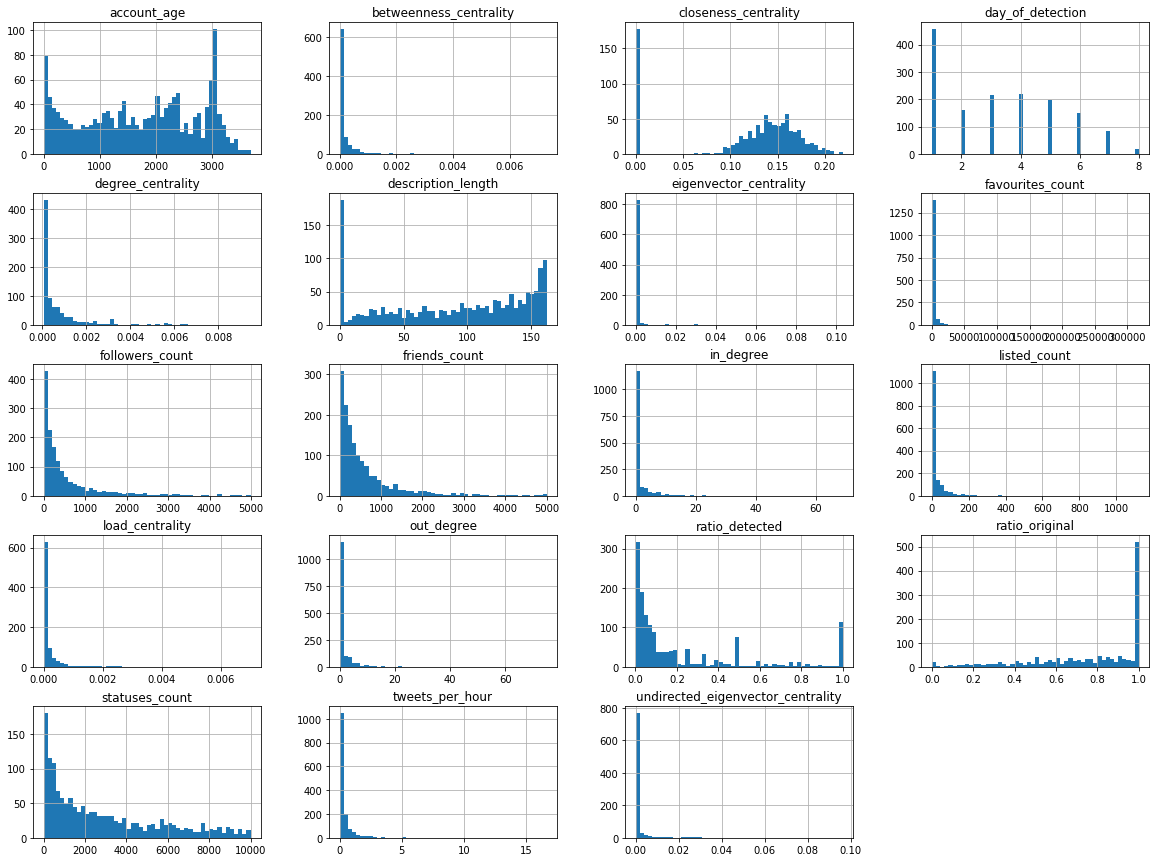

In [135]:
%matplotlib inline

cols_to_drop = ['id', 'user_id']

# Ignore binary columns:
for col in users_df.columns:
    if len(users_df[col].value_counts()) == 2:
        cols_to_drop += [col]

users_df.drop(cols_to_drop, axis=1).hist(bins=50, figsize=(20,15));


##### Notes: 
* account_age has many low values, which may be an error in the age calculation or may simply suggest input from newly created accounts. This could be due to users creating accounts specifically to talk about the event, or bot traffic where bots are likely to be detected and removed over time so they are not represented at larger age values. Need to investigate further.
* account_age has a spike of accounts created around 3000 days prior to the event. This could also be an error in data collection, or could represent a significant event in Twitter's history.
* day_of_detection represents the earliest day an account is detected, so even where behaviour is constant, we expect to see a decrease in these values as accounts are detected a second time. There is a large amount of accounts detected at day=1, which could be an error in the collection or calculation. To be checked.
* ratio_detected has spikes at expected increments: 1, 1/2, 1/3, 1/4 - these are more common as low Tweet count is more common.

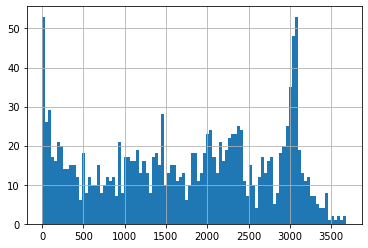

In [176]:
# Look closer at account_age:
users_df['account_age'].hist(bins=100);

The spike at age=3000 appears natural, so is less likely to be a calculation/collection error. Now we can look at the most recent account ages in more detail:

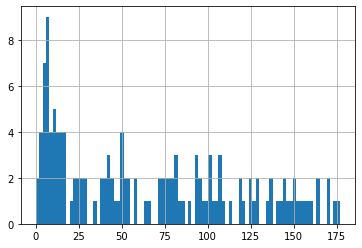

In [184]:
# Histogram of accounts made in the last 6 months:
users_df['account_age'].loc[users_df['account_age'] < 180].hist(bins=90);

There is a clear spike in accounts made up to 20 days prior to the end of the data collection. This may be consistent with regular Twitter usage as bots are recreated, or users may make accounts to participate in the hurricane discussion. This could be compared to a random Twitter stream in future work.

In any case, it does not appear to be a collection error.

Note: the date from which this age was calculated was approximately 7 days after the hurricane made landfall.

In [213]:
# Stratification to ensure proportional representation of class in test set:
# Set category:
# users_df['strat'] = pd.cut(users_df['to_strat'], bins=[0,1.5,2.5, np.inf], labels=[1,2,3])
# Then split with StratifiedShuffleSplit

In [214]:
# Display all columns of DF in cell:
pd.set_option('display.max_columns', None)

# Check available columns
users_df.columns

Index(['added_at', 'betweenness_centrality', 'closeness_centrality',
       'created_at', 'default_profile', 'default_profile_image',
       'degree_centrality', 'description', 'eigenvector_centrality',
       'favourites_count', 'followers_count', 'friends_count', 'geo_enabled',
       'has_extended_profile', 'id', 'in_degree', 'is_translation_enabled',
       'listed_count', 'load_centrality', 'location', 'name',
       'old_screen_name', 'out_degree', 'ratio_detected', 'ratio_original',
       'screen_name', 'statuses_count', 'tweets_per_hour',
       'undirected_eigenvector_centrality', 'url', 'user_id', 'verified',
       'local_profile_location', 'local_timezone', 'coded_as_witness',
       'tweet_from_locality', 'three_local_metrics',
       'local_tw_and_local_profile', 'local_tw_and_local_tz',
       'local_tz_and_local_profile', 'description_length', 'lang_is_en',
       'has_translator_type', 'has_url', 'changed_screen_name', 'account_age',
       'day_of_detection', 'is_use

Columns which are not relevant to the classification problem are dropped, and the test and train partitions are created. 

The column 'local_profile_location_manual' is removed as 'local_profile_location' is preferred for scalability.

Any remaining NAN values are also filled with zeroes. 

The dataframe is also checked for any columns that were not cleaned appropriately (for example, still True/False rather than 1/0)

In [216]:
from sklearn.model_selection import train_test_split

# Excluded features:
dropped_cols = ['added_at', 'description', 'created_at', 'id',  'location', 'name', 'url', 
                'screen_name', 'user_id', 'coded_as_witness', 'old_screen_name']

xVar = users_df.drop(dropped_cols, axis=1)

yVar = users_df['coded_as_witness']

# Partition data sets:
xVar = xVar.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(xVar, yVar, test_size=0.2, random_state=42)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

X_train.head()

(1199, 39) (1199,)
(300, 39) (300,)


,betweenness_centrality,closeness_centrality,default_profile,default_profile_image,degree_centrality,eigenvector_centrality,favourites_count,followers_count,friends_count,geo_enabled,has_extended_profile,in_degree,is_translation_enabled,listed_count,load_centrality,out_degree,ratio_detected,ratio_original,statuses_count,tweets_per_hour,undirected_eigenvector_centrality,verified,local_profile_location,local_timezone,tweet_from_locality,three_local_metrics,local_tw_and_local_profile,local_tw_and_local_tz,local_tz_and_local_profile,description_length,lang_is_en,has_translator_type,has_url,changed_screen_name,account_age,day_of_detection,is_user_class_2,is_data_source_1,is_data_source_3
383,0.000705,0.187359,0,0,0.001397,2.397852e-04,708,3039,1011,1,0,10,0,107,0.000725,3,0.076923,0.769231,6086,0.073456,0.000708,0,0,1,0,0,0,0,0,148,1,0,1,0,3158,5,0,1,0
539,0.000000,0.000000,0,0,0.000000,0.000000e+00,1188,115,299,1,1,0,0,9,0.000000,0,0.040000,0.600000,2688,0.141262,0.000000,0,1,0,1,0,1,0,0,58,1,0,0,0,828,5,0,0,1
1493,0.000000,0.000000,1,0,0.000000,0.000000e+00,56,42,361,0,1,0,0,0,0.000000,0,0.032258,0.870968,840,0.175165,0.000000,0,0,0,0,0,0,0,0,104,0,0,0,0,408,1,0,1,0
1113,0.000000,0.000000,1,0,0.000000,0.000000e+00,7,50,5,0,0,0,0,11,0.000000,0,0.005319,0.867021,5382,1.062289,0.000000,0,0,0,0,0,0,0,0,68,1,0,0,0,780,2,0,1,0
325,0.000000,0.000000,1,0,0.000061,1.764451e-52,39,7,57,0,1,0,0,0,0.000000,1,0.071429,0.857143,75,0.079107,0.000239,0,0,0,0,0,0,0,0,127,1,0,0,1,17,5,0,1,0


## Data Exploration
Check for linear correlations:

In [231]:
# Create copy of training data to investigate
df = X_train.copy()
df['coded_as_witness'] = y_train

corr_matrix = df.corr()
corr_matrix['coded_as_witness'].sort_values(ascending=False)

coded_as_witness                     1.000000
local_profile_location               0.551050
local_tw_and_local_profile           0.437055
tweet_from_locality                  0.424988
is_data_source_3                     0.424988
local_tz_and_local_profile           0.296873
local_tw_and_local_tz                0.268485
ratio_detected                       0.259706
three_local_metrics                  0.253538
geo_enabled                          0.249082
closeness_centrality                 0.170760
ratio_original                       0.138819
local_timezone                       0.138634
lang_is_en                           0.132348
has_extended_profile                 0.116959
betweenness_centrality               0.115513
load_centrality                      0.115172
degree_centrality                    0.114462
account_age                          0.093229
undirected_eigenvector_centrality    0.041267
changed_screen_name                  0.033872
in_degree                         

We can use scatterplot visualisations to detect correlations.

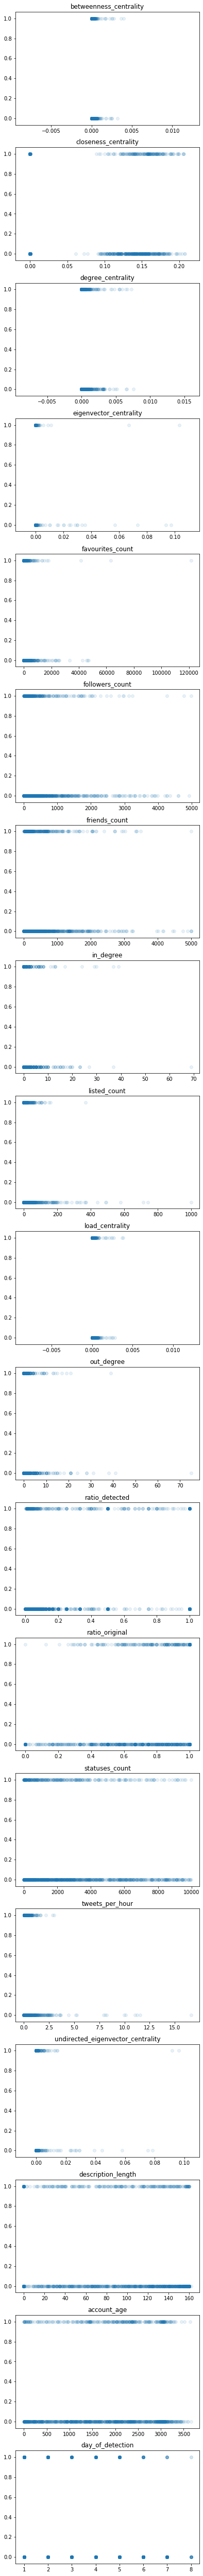

In [272]:
import matplotlib.pyplot as plt

column_list = [x for x in df.columns if len(df[x].value_counts()) != 2]

fig, axes = plt.subplots(len(column_list), figsize=( 6.4, 4.8*len(column_list) ))
for idx, col in enumerate(column_list):
    axes[idx].scatter(df[col], df['coded_as_witness'], alpha=0.1)
    axes[idx].title.set_text(col)

## Classification

The data is now ready for classification. Random forests will be used initially and will suit the relatively small dataset. These will be compared to XGBoost models.

In [323]:
from sklearn.metrics import precision_score, recall_score

def get_results(clf, X_train, y_train, X_test, y_test):
    # Evaluate Training Data
    pred_train = clf.predict(X_train)
    errors_train = sum(abs(pred_train - y_train))
    train_acc = round((1 - errors_train/len(pred_train)) * 100, 2)
    print('Accuracy on Training Data:', train_acc, '%.')
    # Evaluate Test Data
    pred = clf.predict(X_test)
    errors = sum(abs(pred - y_test))
    test_acc = round((1 - errors/len(pred)) * 100, 2)
    print('Accuracy on Test Data:', test_acc, '%.')
    # Evaluate AUC Score
    auc_score = round(roc_auc_score(y_test, pred), 2)
    print('AUC score: ', auc_score)
    # Confusion Matrix:
    print(pd.crosstab(y_test, pred, rownames=['Actual Result'], colnames=['Predicted Result']))
    # Evaluate Precision & Recall:
    prec = round(precision_score(y_test, pred), 2)
    recall = round(recall_score(y_test, pred), 2)
    return(train_acc, test_acc, auc_score, prec, recall)

In [324]:
#from sklearn.metrics import roc_auc_score

results_df = pd.DataFrame(columns=['model', 'train_acc', 'test_acc', 'auc', 'precision', 'recall'])

### Logistic Regression
Logistic Regression using single variable:

In [325]:
from sklearn.linear_model import LogisticRegression
X_train_single = X_train.drop([x for x in X_train.columns if x != 'local_profile_location'], axis=1)
X_test_single = X_test.drop([x for x in X_train.columns if x != 'local_profile_location'], axis=1)
clf = LogisticRegression(random_state=0).fit(X_train_single, y_train)
#clf.score(X_train_single, y_train)

results_df.loc[len(results_df)] = ['logr_localprofile'] + list(get_results(clf, X_train_single, y_train, X_test_single, y_test))

Accuracy on Training Data: 83.15 %.
Accuracy on Test Data: 78.0 %.
AUC score:  0.74
Predicted Result    0   1
Actual Result            
0                 182  38
1                  28  52


In [326]:
X_train_single = X_train.drop([x for x in X_train.columns if x != 'tweet_from_locality'], axis=1)
X_test_single = X_test.drop([x for x in X_train.columns if x != 'tweet_from_locality'], axis=1)
clf = LogisticRegression(random_state=0).fit(X_train_single, y_train)
#clf.score(X_train_single, y_train)

results_df.loc[len(results_df)] = ['logr_localtweet'] + list(get_results(clf, X_train_single, y_train, X_test_single, y_test))

Accuracy on Training Data: 76.9 %.
Accuracy on Test Data: 76.67 %.
AUC score:  0.75
Predicted Result    0   1
Actual Result            
0                 174  46
1                  24  56


Logistic Regression using all variables

In [327]:
from sklearn.linear_model import LogisticRegression
#.drop([x for x in X_train.columns if x != 'local_profile_location'], axis=1)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
#clf.score(X_train, y_train)
results_df.loc[len(results_df)] = ['logr'] + list(get_results(clf, X_train, y_train, X_test, y_test))

Accuracy on Training Data: 83.9 %.
Accuracy on Test Data: 78.33 %.
AUC score:  0.73
Predicted Result    0   1
Actual Result            
0                 187  33
1                  32  48


In [329]:
results_df

,model,train_acc,test_acc,auc,precision,recall
0,logr_localprofile,83.15,78.00,0.74,0.58,0.65
1,logr_localtweet,76.90,76.67,0.75,0.55,0.70
2,logr,83.90,78.33,0.73,0.59,0.60


### Random Forest
A baseline RandomForest classifier is created for comparison to parameter-tuned models.

In [330]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_jobs=-1, random_state=0, n_estimators=100)
clf.fit(X_train, y_train)
results_df.loc[len(results_df)] = ['rfc_baseline'] + list(get_results(clf, X_train, y_train, X_test, y_test))

Accuracy on Training Data: 100.0 %.
Accuracy on Test Data: 81.67 %.
AUC score:  0.77
Predicted Result    0   1
Actual Result            
0                 192  28
1                  27  53


In [333]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_jobs': [-1],
    'class_weight': ['balanced'],
    'bootstrap': [True],
#    'max_depth': [2, 10, 20, 50, 100],
    'max_depth': [10, 50, 100],
#    'max_features': [0.1, 0.2, 0.3, 0.4, 'sqrt', 'log2'],
    'max_features': [0.4, 'sqrt', 'log2'],
#    'min_samples_leaf': [1, 2, 3],
#    'min_samples_split': [2, 3, 5],
#    'n_estimators': [10, 15, 20, 40, 60, 100, 200, 300, 400, 500, 600, 700, 800],
    'n_estimators': [300, 400, 600],
    'criterion': ['gini']
}

rfc = RandomForestClassifier() 

clf = GridSearchCV(rfc, param_grid, scoring='roc_auc')
clf.fit(X_train, y_train)
best_clf_rf = clf.best_estimator_
best_params_rf = clf.best_params_

print(best_clf_rf)

results_df.loc[len(results_df)] = ['rfc_gs'] + list(get_results(best_clf_rf, X_train, y_train, X_test, y_test))
results_df

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy on Training Data: 96.83 %.
Accuracy on Test Data: 82.0 %.
AUC score:  0.79
Predicted Result    0   1
Actual Result            
0                 189  31
1                  23  57


,model,train_acc,test_acc,auc,precision,recall
0,logr_localprofile,83.15,78.00,0.74,0.58,0.65
1,logr_localtweet,76.90,76.67,0.75,0.55,0.70
2,logr,83.90,78.33,0.73,0.59,0.60
3,rfc_baseline,100.00,81.67,0.77,0.65,0.66
4,rfc_gs,96.83,82.00,0.79,0.65,0.71


### Feature Pruning
We can check the importance of each feature as per the model and use these values to inform the choice of features in future iterations.

In [334]:
feat_importance = sorted(list(zip(X_train, best_clf_rf.feature_importances_.round(decimals=2))), key=lambda x: x[1], reverse=True)
feat_importance

[('local_profile_location', 0.17),
 ('ratio_detected', 0.05),
 ('tweet_from_locality', 0.05),
 ('is_data_source_3', 0.05),
 ('favourites_count', 0.04),
 ('followers_count', 0.04),
 ('listed_count', 0.04),
 ('ratio_original', 0.04),
 ('statuses_count', 0.04),
 ('undirected_eigenvector_centrality', 0.04),
 ('description_length', 0.04),
 ('account_age', 0.04),
 ('is_data_source_1', 0.04),
 ('closeness_centrality', 0.03),
 ('friends_count', 0.03),
 ('tweets_per_hour', 0.03),
 ('local_tw_and_local_profile', 0.03),
 ('day_of_detection', 0.03),
 ('betweenness_centrality', 0.02),
 ('degree_centrality', 0.02),
 ('eigenvector_centrality', 0.02),
 ('load_centrality', 0.02),
 ('out_degree', 0.02),
 ('local_tz_and_local_profile', 0.02),
 ('default_profile', 0.01),
 ('geo_enabled', 0.01),
 ('has_extended_profile', 0.01),
 ('in_degree', 0.01),
 ('local_tw_and_local_tz', 0.01),
 ('has_url', 0.01),
 ('default_profile_image', 0.0),
 ('is_translation_enabled', 0.0),
 ('verified', 0.0),
 ('local_timezone'

In [335]:
# Remove features with lowest importance:
features_to_remove = [x[0] for x in feat_importance if x[1] < 0.01]
# We can also remove features which are duplicated:
duplicated_features = ['local_tz_and_local_profile']
features_to_remove += duplicated_features

In [339]:
# Temporary storage
X_train_unpruned = X_train
X_test_unpruned = X_test

# Prune
X_train = X_train.drop(features_to_remove, axis=1)
X_test = X_test.drop(features_to_remove, axis=1)

# Use params from previous GridSearch (may not be optimal given pruned set)
clf = RandomForestClassifier().set_params(**best_params_rf)
clf.fit(X_train, y_train)
results_df.loc[len(results_df)] = ['rfc_pruned_0.01'] + list(get_results(clf, X_train, y_train, X_test, y_test))


############ Second round of pruning ############

# Remove features with lowest importance:
features_to_remove = [x[0] for x in feat_importance if x[1] < 0.02 and x[1] >= 0.01 and x[0] not in duplicated_features]
X_train = X_train.drop(features_to_remove, axis=1)
X_test = X_test.drop(features_to_remove, axis=1)

# Use params from previous GridSearch (may not be optimal given pruned set)
clf = RandomForestClassifier().set_params(**best_params_rf)
clf.fit(X_train, y_train)
results_df.loc[len(results_df)] = ['rfc_pruned_0.02'] + list(get_results(clf, X_train, y_train, X_test, y_test))


# Unprune datasets
X_train = X_train_unpruned
X_test = X_test_unpruned 

results_df

Accuracy on Training Data: 97.41 %.
Accuracy on Test Data: 82.33 %.
AUC score:  0.78
Predicted Result    0   1
Actual Result            
0                 191  29
1                  24  56
Accuracy on Training Data: 97.33 %.
Accuracy on Test Data: 83.67 %.
AUC score:  0.81
Predicted Result    0   1
Actual Result            
0                 192  28
1                  21  59


,model,train_acc,test_acc,auc,precision,recall
0,logr_localprofile,83.15,78.00,0.74,0.58,0.65
1,logr_localtweet,76.90,76.67,0.75,0.55,0.70
2,logr,83.90,78.33,0.73,0.59,0.60
3,rfc_baseline,100.00,81.67,0.77,0.65,0.66
4,rfc_gs,96.83,82.00,0.79,0.65,0.71
5,rfc_pruned_0.01,97.41,82.33,0.78,0.66,0.70
6,rfc_pruned_0.02,97.33,83.67,0.81,0.68,0.74


### XGBoost

In [340]:
from xgboost import XGBClassifier

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Baseline model
clf = XGBClassifier(max_depth=6, eval_metric='auc')
clf.fit(X_train, y_train)
results_df.loc[len(results_df)] = ['xgb_baseline'] + list(get_results(clf, X_train, y_train, X_test, y_test))

Accuracy on Training Data: 99.92 %.
Accuracy on Test Data: 82.0 %.
AUC score:  0.77
Predicted Result    0   1
Actual Result            
0                 193  27
1                  27  53


In [341]:
# Set weights for unbalanced classes as their proportion:
total = sum(y_train.value_counts())
y_weights = y_train.apply(lambda x: (total-y_train.value_counts()[x]) /
                          y_train.value_counts()[x])
clf = XGBClassifier(max_depth=6, eval_metric='auc')
clf.fit(X_train, y_train, sample_weight=y_weights)
results_df.loc[len(results_df)] = ['xgb_weighted'] + list(get_results(clf, X_train, y_train, X_test, y_test))

results_df

Accuracy on Training Data: 96.25 %.
Accuracy on Test Data: 81.33 %.
AUC score:  0.81
Predicted Result    0   1
Actual Result            
0                 180  40
1                  16  64


,model,train_acc,test_acc,auc,precision,recall
0,logr_localprofile,83.15,78.00,0.74,0.58,0.65
1,logr_localtweet,76.90,76.67,0.75,0.55,0.70
2,logr,83.90,78.33,0.73,0.59,0.60
3,rfc_baseline,100.00,81.67,0.77,0.65,0.66
4,rfc_gs,96.83,82.00,0.79,0.65,0.71
5,rfc_pruned_0.01,97.41,82.33,0.78,0.66,0.70
6,rfc_pruned_0.02,97.33,83.67,0.81,0.68,0.74
7,xgb_baseline,99.92,82.00,0.77,0.66,0.66
8,xgb_weighted,96.25,81.33,0.81,0.62,0.80


In [ ]:
from sklearn.model_selection import GridSearchCV

# negative_instances / positive_instances (for scale_pos_weight) = 
neg_proportion = (len(y_train)-sum(y_train)) / sum(y_train)

param_grid = {
    'max_depth': [6, 7, 8, 10],
#    'max_depth': [6, 10, 30],
    'eval_metric' : ['auc'],
#    'gamma' : [0, 0.5, 1, 2, 5],
    'gamma' : [1],
#    'learning_rate' : [0.05, 0.1, 0.3, 0.5],
    'learning_rate' : [0.05, 0.1],
    'max_delta_step' : [0, 1],
#    'n_estimators' : [5, 10, 50, 100, 200, 300],
    'n_estimators' : [200, 300],
    'n_jobs' : [-1],
    'scale_pos_weight' : [1],
    'min_child_weight' : [0, 1, 5]
}

xgb = XGBClassifier()

clf = GridSearchCV(xgb, param_grid, scoring='roc_auc')
clf.fit(X_train, y_train, sample_weight=y_weights)
best_clf_xgb = clf.best_estimator_
best_params_xgb = clf.best_params_

results_df.loc[len(results_df)] = ['xgb_weighted_gs'] + list(get_results(best_clf_xgb, X_train, y_train, X_test, y_test))
print(best_clf_xgb)

results_df

In [ ]:
feat_importance = sorted(list(zip(X_train, best_clf_xgb.feature_importances_.round(decimals=2))), key=lambda x: x[1], reverse=True)
feat_importance

Notes from feature importance:
* Geographic features are expectedly the top two features
* The four local combination metrics are not important (three_local_metrics, local_tw_and_local_profile, local_tw_and_local_tz, local_tz_and_local_profile)
* data_source and user_class are unimportant
* betweeness_centrality and undirected_eigenvector_centrality are the most important network metrics
* day_of_detection is more important than expected

### Compare to Model Without Network Metrics
Network metrics are expensive to obtain from the Twitter API, yet they appear to be important to the above models.

We can test equivalent models excluding these features to measure their true value.

In [ ]:
# Temporary storage of unpruned dataset
X_train_unpruned = X_train
X_test_unpruned = X_test


features_to_remove = ['undirected_eigenvector_centrality', 'degree_centrality', 'closeness_centrality', 
                      'eigenvector_centrality', 'load_centrality', 'betweenness_centrality']
X_train = X_train.drop(features_to_remove, axis=1)
X_test = X_test.drop(features_to_remove, axis=1)


# Use params from previous GridSearch (may not be optimal given pruned set)
clf = RandomForestClassifier().set_params(**best_params_rf)
clf.fit(X_train, y_train)
results_df.loc[len(results_df)] = ['rfc_no_network'] + list(get_results(clf, X_train, y_train, X_test, y_test))

xgb = XGBClassifier().set_params(**best_params_xgb)
xgb.fit(X_train, y_train)
results_df.loc[len(results_df)] = ['xgb_no_network'] + list(get_results(xgb, X_train, y_train, X_test, y_test))


# Unprune datasets
X_train = X_train_unpruned
X_test = X_test_unpruned 

results_df

As shown above, removing network features from the XGB model causes a significant drop in AUC, precision and recall. The biggest change is in recall, and as this is the most important feature in this application, we must consider collecting these.

In [ ]:
xVar.columns

In [ ]:
# Which features are not available at the time of Tw detection or update throughout event?

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# negative_instances / positive_instances (for scale_pos_weight) = 
neg_proportion = (len(y_train)-sum(y_train)) / sum(y_train)

param_grid = {
    'max_depth': [6, 7, 8, 10],
#    'max_depth': [6, 10, 30],
    'eval_metric' : ['auc'],
#    'gamma' : [0, 0.5, 1, 2, 5],
    'gamma' : [1],
#    'learning_rate' : [0.05, 0.1, 0.3, 0.5],
    'learning_rate' : [0.05, 0.1],
    'max_delta_step' : [0, 1],
#    'n_estimators' : [5, 10, 50, 100, 200, 300],
    'n_estimators' : [200, 300],
    'n_jobs' : [-1],
    'scale_pos_weight' : [1],
    'min_child_weight' : [0, 1, 5]
}

param_grid = {"learning_rate": [0.1, 0.01, 0.001],
               "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               "max_depth": [2, 4, 7, 10],
               "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
               "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
               "reg_alpha": [0, 0.5, 1],
               "reg_lambda": [1, 1.5, 2, 3, 4.5],
               "min_child_weight": [1, 3, 5, 7],
               "n_estimators": [100, 250, 500, 1000]}

xgb = XGBClassifier(verbosity = True, objective = 'binary:logistic', eval_metric = 'roc_auc')
xgb = XGBClassifier()
#xgb_clf = xgb.XGBClassifier(tree_method = "gpu_exact", predictor = "gpu_predictor", verbosity = True
#                           eval_metric = ["merror", "map", "auc"], objective = "multi:softmax")

#clf = GridSearchCV(xgb, param_grid, scoring='roc_auc')
clf = RandomizedSearchCV(xgb, param_distributions = param_grid, scoring = "roc_auc",
                            cv = 5, verbose = 3, random_state = 40,
                            n_iter = 20)
clf.fit(X_train, y_train, sample_weight=y_weights)
best_clf_xgb = clf.best_estimator_
best_params_xgb = clf.best_params_

results_df.loc[len(results_df)] = ['xgb_weighted_gs'] + list(get_results(best_clf_xgb, X_train, y_train, x_test, y_test))
print(best_clf_xgb)
print(get_results(best_clf_xgb))
results_df

In [ ]:
results_df